In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import efficientnet_b5, EfficientNet_B5_Weights
from albumentations.pytorch import ToTensorV2
import albumentations as A
import cv2
import random
from torch.utils.data import Dataset, DataLoader

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DRIVE_PATH = "/content/drive/MyDrive"

In [4]:
# load config
with open(os.path.join(DRIVE_PATH, 'config.json')) as f:
    config = json.load(f)

# load full state
def load_state(path):
    with open(path, 'r') as f:
        state = json.load(f)
    print(f"✅ Loaded full state from {path}")
    return (
        state['config'],
        state['split_idx'],
        state['known_classes'],
        state['unknown_classes'],
        state['known_train_paths'],
        state['known_val_paths'],
        state['unknown_val_paths']
    )

config, split_idx, known_classes, unknown_classes, known_train_paths, known_val_paths, unknown_val_paths = load_state(
    os.path.join(DRIVE_PATH, 'full_state.json')
)

✅ Loaded full state from /content/drive/MyDrive/full_state.json


In [5]:
class TripletDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.transform = transform
        self.label_to_images = {}
        for p in image_paths:
            label = p.split(os.sep)[-2]
            self.label_to_images.setdefault(label, []).append(p)
        self.labels = list(self.label_to_images.keys())

    def __len__(self):
        return 10000

    def __getitem__(self, idx):
        anchor_label = random.choice(self.labels)
        negative_label = random.choice([l for l in self.labels if l != anchor_label])
        anchor_path = random.choice(self.label_to_images[anchor_label])
        positive_path = random.choice(self.label_to_images[anchor_label])
        negative_path = random.choice(self.label_to_images[negative_label])

        def load(path):
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            return self.transform(image=img)['image']

        return load(anchor_path), load(positive_path), load(negative_path)

transform_eval = A.Compose([
    A.Resize(config['img_size'], config['img_size']),
    A.Normalize(),
    ToTensorV2()
])

In [6]:
val_dataset = TripletDataset(known_val_paths, transform=transform_eval)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [7]:
transform_train = A.Compose([
    A.Resize(config['img_size'], config['img_size']),
    A.HorizontalFlip(),
    A.Normalize(),
    ToTensorV2()
])

train_dataset = TripletDataset(known_train_paths, transform=transform_train)
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=4)

In [8]:
class Encoder(nn.Module):
    def __init__(self, embedding_dim, freeze_backbone=True):
        super().__init__()
        weights = EfficientNet_B5_Weights.IMAGENET1K_V1
        self.backbone = efficientnet_b5(weights=weights)
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, embedding_dim)
        )
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False

    def forward(self, x):
        x = self.backbone(x)
        return self.head(x)

In [9]:
def load_checkpoint(model_class, optimizer_class, embedding_dim, lr, checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
    freeze = checkpoint.get('freeze_backbone', True)

    model = model_class(embedding_dim=embedding_dim, freeze_backbone=freeze).to(DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])

    if freeze:
        optimizer = optimizer_class(model.head.parameters(), lr=lr)
    else:
        for p in model.backbone.parameters():
            p.requires_grad = True
        optimizer = optimizer_class(model.parameters(), lr=lr * 0.1)

    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"🔁 Resumed from epoch {checkpoint['epoch']} (freeze_backbone={freeze})")
    return model, optimizer, checkpoint['epoch'], freeze

In [11]:
model, optimizer, start_epoch, freeze_backbone = load_checkpoint(
    model_class=Encoder,
    optimizer_class=torch.optim.Adam,
    embedding_dim=config['embedding_dim'],
    lr=config['learning_rate'],
    checkpoint_path=config['checkpoint_path']
)

Downloading: "https://download.pytorch.org/models/efficientnet_b5_lukemelas-1a07897c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b5_lukemelas-1a07897c.pth
100%|██████████| 117M/117M [00:01<00:00, 120MB/s]


🔁 Resumed from epoch 11 (freeze_backbone=False)


In [12]:
class FeatureDataset(Dataset):
    def __init__(self, image_paths, transform):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.transform(image=img)['image']
        label = path.split(os.sep)[-2]
        return img, label, path

In [19]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# مدل Encoder (مثلا با EfficientNet-B5)
class Encoder(nn.Module):
    def __init__(self, embedding_dim, freeze_backbone=True):
        super().__init__()
        weights = EfficientNet_B5_Weights.IMAGENET1K_V1
        self.backbone = efficientnet_b5(weights=weights)
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, embedding_dim)
        )
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False

    def forward(self, x):
        x = self.backbone(x)
        return self.head(x)

# تابع محاسبه triplet loss
def triplet_loss(anchor, positive, negative, margin=1.0):
    pos_dist = F.pairwise_distance(anchor, positive)
    neg_dist = F.pairwise_distance(anchor, negative)
    loss = torch.relu(pos_dist - neg_dist + margin)
    return loss.mean()

# ذخیره چک‌پوینت (مدل + آپتیمایزر + اپوک + وضعیت freeze)
def save_checkpoint(model, optimizer, epoch, freeze_backbone, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'freeze_backbone': freeze_backbone,
    }, path)
    print(f"💾 Checkpoint saved after epoch {epoch}")

# بارگذاری چک‌پوینت
def load_checkpoint(model_class, optimizer_class, embedding_dim, lr, checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
    freeze = checkpoint.get('freeze_backbone', True)

    model = model_class(embedding_dim=embedding_dim, freeze_backbone=freeze).to(DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])

    if freeze:
        optimizer = optimizer_class(model.head.parameters(), lr=lr)
    else:
        for p in model.backbone.parameters():
            p.requires_grad = True
        optimizer = optimizer_class(model.parameters(), lr=lr * 0.1)

    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    start_epoch = checkpoint['epoch']
    print(f"🔁 Resumed from epoch {start_epoch} (freeze_backbone={freeze})")
    return model, optimizer, start_epoch, freeze

# تابع اعتبارسنجی
def evaluate(model, val_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for anc, pos, neg in val_loader:
            anc, pos, neg = anc.to(DEVICE), pos.to(DEVICE), neg.to(DEVICE)
            e_anc = model(anc)
            e_pos = model(pos)
            e_neg = model(neg)
            loss = triplet_loss(e_anc, e_pos, e_neg)
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Validation Loss: {avg_loss:.4f}")
    model.train()
    return avg_loss

# حلقه آموزش با ادامه از checkpoint
def train_encoder_with_checkpoint(model_class, train_loader, val_loader, embedding_dim, lr, checkpoint_path, total_epochs, freeze_epochs):
    start_epoch = 0
    freeze_backbone = True
    best_val_loss = float('inf')

    if os.path.exists(checkpoint_path):
        model, optimizer, start_epoch, freeze_backbone = load_checkpoint(
            model_class=model_class,
            optimizer_class=optim.Adam,
            embedding_dim=embedding_dim,
            lr=lr,
            checkpoint_path=checkpoint_path,
        )
    else:
        model = model_class(embedding_dim=embedding_dim, freeze_backbone=True).to(DEVICE)
        optimizer = optim.Adam(model.head.parameters(), lr=lr)

    model.train()

    for epoch in range(start_epoch, total_epochs):
        print(f"Epoch {epoch+1}/{total_epochs} - Freeze backbone: {freeze_backbone}")
        total_loss = 0
        for anc, pos, neg in tqdm(train_loader):
            anc, pos, neg = anc.to(DEVICE), pos.to(DEVICE), neg.to(DEVICE)
            optimizer.zero_grad()
            e_anc = model(anc)
            e_pos = model(pos)
            e_neg = model(neg)
            loss = triplet_loss(e_anc, e_pos, e_neg)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}")

        val_loss = evaluate(model, val_loader)

        save_checkpoint(model, optimizer, epoch+1, freeze_backbone, checkpoint_path)

        # if val_loss < best_val_loss:
        #     best_val_loss = val_loss
        #     best_path = checkpoint_path.replace('.pth', '_best.pth')
        #     torch.save(model.state_dict(), best_path)
        #     print(f"🔥 Best model saved")

        if freeze_backbone and (epoch + 1) >= freeze_epochs:
            print("🔓 Unfreezing backbone and updating optimizer...")
            freeze_backbone = False
            for p in model.backbone.parameters():
                p.requires_grad = True
            optimizer = optim.Adam(model.parameters(), lr=lr * 0.1)

    print("✅ Training complete")
    return model

In [20]:
model = train_encoder_with_checkpoint(
    model_class=Encoder,
    train_loader=train_loader,
    val_loader=val_loader,
    embedding_dim=128,
    lr=1e-4,
    checkpoint_path="/content/drive/MyDrive/checkpoints/encoder_triplet.pth",
    total_epochs=16,  # مثلا 5 اپوک بیشتر از قبل
    freeze_epochs=5
)

🔁 Resumed from epoch 12 (freeze_backbone=False)
Epoch 13/16 - Freeze backbone: False


100%|██████████| 625/625 [05:54<00:00,  1.76it/s]

Epoch 13 - Train Loss: 0.0068


Validation Loss: 0.0055
💾 Checkpoint saved after epoch 13
Epoch 14/16 - Freeze backbone: False


100%|██████████| 625/625 [06:01<00:00,  1.73it/s]

Epoch 14 - Train Loss: 0.0058


Validation Loss: 0.0046
💾 Checkpoint saved after epoch 14
Epoch 15/16 - Freeze backbone: False


100%|██████████| 625/625 [05:59<00:00,  1.74it/s]

Epoch 15 - Train Loss: 0.0056


Validation Loss: 0.0046
💾 Checkpoint saved after epoch 15
Epoch 16/16 - Freeze backbone: False


100%|██████████| 625/625 [06:01<00:00,  1.73it/s]

Epoch 16 - Train Loss: 0.0044


Validation Loss: 0.0032
💾 Checkpoint saved after epoch 16
✅ Training complete


In [21]:
def extract_embeddings(model, image_paths, transform):
    dataset = FeatureDataset(image_paths, transform)
    loader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=False)
    model.eval()
    all_embeddings, all_labels, all_paths = [], [], []
    with torch.no_grad():
        for imgs, labels, paths in loader:
            imgs = imgs.to(DEVICE)
            embeddings = model(imgs).cpu()
            all_embeddings.append(embeddings)
            all_labels.extend(labels)
            all_paths.extend(paths)
    return torch.cat(all_embeddings), all_labels, all_paths

from sklearn.neighbors import NearestNeighbors

known_embeddings, known_labels, known_paths = extract_embeddings(model, known_train_paths, transform_eval)
knn = NearestNeighbors(n_neighbors=1)
knn.fit(known_embeddings)

NearestNeighbors(n_neighbors=1)

In [22]:
val_paths = known_val_paths + unknown_val_paths
val_labels = [p.split(os.sep)[-2] for p in val_paths]

val_embeddings, _, _ = extract_embeddings(model, val_paths, transform_eval)
dists, _ = knn.kneighbors(val_embeddings)

import numpy as np
from sklearn.metrics import precision_recall_curve

true_known = np.array([1 if l in known_classes else 0 for l in val_labels])
prec, rec, thresholds = precision_recall_curve(true_known, -dists.flatten())
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-6)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"✅ Best Threshold: {best_threshold:.3f}, F1 Score: {f1_scores[best_idx]:.3f}")


✅ Best Threshold: -3.095, F1 Score: 0.953


In [23]:
import glob
import os
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# 🔹 مسیر تصاویر تست
test_root = os.path.join(DRIVE_PATH, 'test')  # مسیر داده‌های تست: /content/drive/MyDrive/test

# 🔹 گرفتن مسیر تمام تصاویر
test_paths = glob.glob(os.path.join(test_root, '*', '*.jpg'))

# 🔹 گرفتن لیبل واقعی از نام پوشه
test_labels = [p.split(os.sep)[-2] for p in test_paths]

# 🔹 استخراج embedding با مدل
test_embeddings, _, _ = extract_embeddings(model, test_paths, transform_eval)

# 🔹 پیدا کردن نزدیک‌ترین همسایه در بین داده‌های train
test_dists, test_indices = knn.kneighbors(test_embeddings)

# 🔹 پیش‌بینی نهایی: شناخته شده یا ناشناخته + آیدی در صورت شناخته بودن
preds = []
for dist, idx in zip(test_dists, test_indices):
    if -dist[0] > best_threshold:
        preds.append(known_labels[idx[0]])  # آیدی شناخته شده
    else:
        preds.append("unknown")  # ناشناخته

# 🔹 لیبل واقعی: اگه در known_classes نباشه، پس ناشناخته‌ست
true_cleaned = [label if label in known_classes else "unknown" for label in test_labels]

# 🔹 گزارش نهایی
print("📊 Test Results:")
print("Acc =", accuracy_score(true_cleaned, preds))
print("Prec =", precision_score(true_cleaned, preds, average='macro', zero_division=0))
print("Rec =", recall_score(true_cleaned, preds, average='macro', zero_division=0))
print("F1 =", f1_score(true_cleaned, preds, average='macro', zero_division=0))


📊 Test Results:
Acc = 0.8921370967741935
Prec = 0.9115775579849876
Rec = 0.9215350843010417
F1 = 0.9066507844290114


In [24]:
import pandas as pd

def save_test_results(paths, true_labels, pred_labels, save_dir, filename="test_results.csv"):
    os.makedirs(save_dir, exist_ok=True)
    df = pd.DataFrame({
        'path': paths,
        'true_label': true_labels,
        'predicted_label': pred_labels,
        'is_known': [true != "unknown" for true in true_labels]
    })
    df.to_csv(os.path.join(save_dir, filename), index=False)
    print(f"✅ Results saved to {os.path.join(save_dir, filename)}")

# فرض کن save_dir رو تعریف کردی مثلا:
save_dir = os.path.join(DRIVE_PATH, 'results')

save_test_results(test_paths, true_cleaned, preds, save_dir)


✅ Results saved to /content/drive/MyDrive/results/test_results.csv


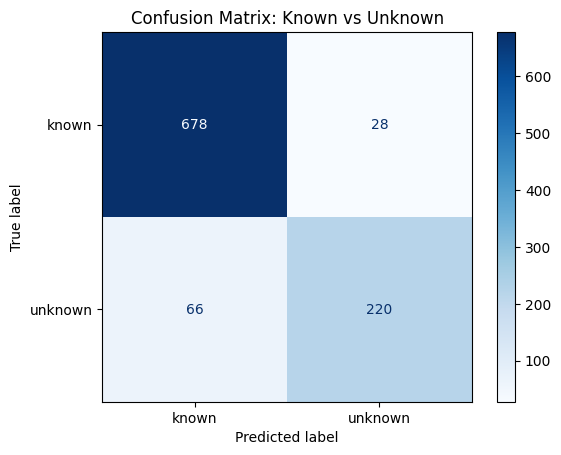

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 🔹 ساخت لیبل‌های باینری برای true و predicted
true_binary = ['known' if lbl != 'unknown' else 'unknown' for lbl in true_cleaned]
pred_binary = ['known' if lbl != 'unknown' else 'unknown' for lbl in preds]

# 🔹 محاسبه و رسم ماتریس
cm = confusion_matrix(true_binary, pred_binary, labels=['known', 'unknown'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['known', 'unknown'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix: Known vs Unknown")
plt.show()


In [27]:
# فقط نمونه‌هایی که در واقعیت شناخته‌شده هستن
known_mask = [label in known_classes for label in test_labels]

# لیبل‌های واقعی برای شناخته‌شده‌ها
true_known = [label for label in test_labels if label in known_classes]

# پیش‌بینی‌های متناظر
pred_known = [pred for pred, is_known in zip(preds, known_mask) if is_known]

# محاسبه تعداد درست‌ها
correct = sum([pred == true for pred, true in zip(pred_known, true_known)])

# درصد پیش‌بینی درست آیدی در میان شناخته‌شده‌ها
accuracy_known_id = correct / len(true_known) if len(true_known) > 0 else 0

print(f"🎯 Accuracy of ID prediction for known samples: {accuracy_known_id:.3f} ({correct}/{len(true_known)})")


🎯 Accuracy of ID prediction for known samples: 0.942 (665/706)
